The next few notebooks are going to be about each classification method - training the default classifier on the train set, testing it out on the test set, hyperparameter tuning the classifier on train set, and finally testing the best model (among the hyperparameters tuned) on the test set. The hyperparameter tuning is supposed to generate a lot of output - I decided to keep it out of the notebooks, and redirect it to log files. For functions involving log files (and also the test_results function I used in the MultinomialNB notebook), I created a separate python file (loggingScoring.py) - that I will be importing in the next notebooks.

In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import loggingScoring as ls

### Initiating Logging

In [2]:
log = ls.get_logfile('2.log')
log.info('Logistic Regression')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

## Model

In [4]:
default_params = LogisticRegression().get_params()
print('Default Parameters of LogisticRegression :\n{}'.format(default_params))

Default Parameters of LogisticRegression :
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Fit time: 0.79 s / Predict time: 0.001 s ---- Precision: 0.954 / Recall: 0.949 / Accuracy: 0.953

Classification Report :

              precision    recall  f1-score   support

        Real       0.95      0.96      0.96      3187
        Fake       0.95      0.95      0.95      2936

    accuracy                           0.95      6123
   macro avg       0.95      0.95      0.95      6123
weighted avg       0.95      0.95      0.95      6123

ROC AUC Score : 0.9532752479632431


Confusion Matrix :



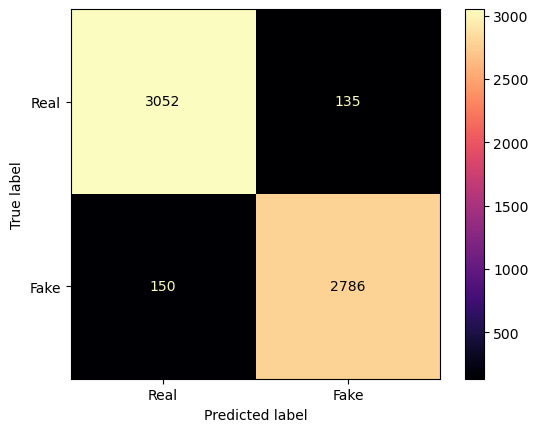

In [5]:
logreg = LogisticRegression(random_state = 76)

start = time.time()
logreg_model = logreg.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = logreg_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

This is promising, the default Logistic Regressor already performs better than our baseline. Before moving on to Hyperparameter tuning, I want to see whether there was any change to the default parameters of the regressor while training. 

In [6]:
new_params = logreg_model.get_params()
del new_params['random_state'], default_params['random_state']
# since we are manually setting random_state, removing that from comparison
if (default_params == new_params):
    print('No change observed in the Default Logistic Regression',\
                                    'parameters after fitting the data.')
else:
    print('Default Logistic Regression changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

No change observed in the Default Logistic Regression parameters after fitting the data.


### Hyperparameter Tuning

In [7]:
logreg_cv = LogisticRegression(max_iter = 1000, random_state = 76)

params = [
    {
        'solver' : ['lbfgs', 'newton-cg', 'sag'],
        # lbfgs, newton-cg, sag, newton-cholesky solvers support only l2 or none penalties
        # newton-cholesky couldn't work with this many features, ran out of memory
        # since it 'has a quadratic dependency on n_features because it explicitly computes the Hessian matrix' - from the doc
        'penalty' : ['l2'],
        'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 12, 24, 35, 50, 100, 250, 750, 2000, 5000]
    },
    {
        'solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'penalty' : [None]
        # Setting penalty=None will ignore the C and l1_ratio parameters
    },
    {
        'solver' : ['saga'], # only saga solver supports elasticnet penalty
        'penalty' : ['elasticnet'],
        'l1_ratio' : np.linspace(0, 1, 4), # l1_ratio must be specified when penalty is elasticnet
        # 'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 12, 24, 35, 50, 100, 250, 750, 2000, 5000]
        # elasticnet with large C values (less regularization) and non-zero l1_ratio
        # (zero l1_ratio indicates pure l2, l1_ratio of 0.33, i.e., 33% l1 & 66% l2, is taking the longest)
        # is taking very long time to run, hence decided to reduce the value range
        'C' : [0.001, 0.01, 0.1, 0.5, 1, 5, 15, 30, 100, 500, 1000, 3000]
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2'],
        'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 12, 24, 35, 50, 100, 250, 750, 2000, 5000]
    },
    {
        'solver' : ['liblinear'], # liblinear solver only supports l1 or l2 penalties
        'penalty' : ['l1', 'l2'],
        'C' : [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 12, 24, 35, 50, 100, 250, 750, 2000, 5000]
    }
]

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)

gs = GridSearchCV(estimator = logreg_cv,
                  param_grid = params,
                  cv = skf,
                  scoring = 'accuracy',
                  verbose = 3)

In [8]:
ls.divert_stdOut2log(log) # redirecting grid search output to log
gs_fit = gs.fit(X_train, y_train)
ls.revert_log2stdOut() # reverting stdout changes, so that results can be printed on notebook
print('Grid Search Done.')
df_cv_results = pd.DataFrame(gs_fit.cv_results_)\
                            .sort_values('mean_test_score', ascending = False)
df_cv_results.to_csv(datapath / 'HPTuningResults' / 'LogisticRegression_cv-results.csv', index = False)
df_cv_results[['params', 'mean_test_score']].head(10)

Grid Search Done.


,params,mean_test_score
76,"{'C': 15, 'l1_ratio': 0.0, 'penalty': 'elastic...",0.958497
147,"{'C': 12, 'penalty': 'l2', 'solver': 'liblinear'}",0.958439
145,"{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",0.958439
20,"{'C': 5, 'penalty': 'l2', 'solver': 'sag'}",0.958439
115,"{'C': 12, 'penalty': 'l2', 'solver': 'saga'}",0.958410
113,"{'C': 5, 'penalty': 'l2', 'solver': 'saga'}",0.958410
72,"{'C': 5, 'l1_ratio': 0.0, 'penalty': 'elasticn...",0.958410
23,"{'C': 12, 'penalty': 'l2', 'solver': 'sag'}",0.958353
19,"{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}",0.958324
18,"{'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.958324


### Best Model

Fit time: 9.44 s / Predict time: 0.001 s ---- Precision: 0.956 / Recall: 0.951 / Accuracy: 0.956

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.95      0.95      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.95539525781252


Confusion Matrix :



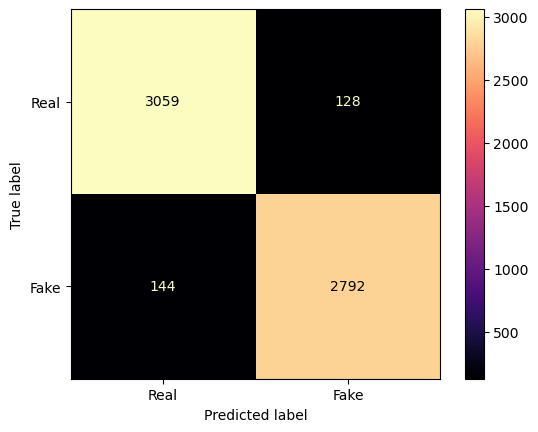

In [10]:
best_logreg = LogisticRegression(solver = 'saga',
                                 penalty = 'elasticnet',
                                 C = 15,
                                 l1_ratio = 0,
                                 max_iter = 1000,
                                 random_state = 76)

start = time.time()
best_logreg_model = best_logreg.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = best_logreg_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)